# Blood Smears Classification

We'll compare the performance of a dense neural network and of a convolutional neural network for the classification of blood smears in the Malaria dataset.

In [1]:
import sys
sys.path.insert(0, "../../../")

## Load Data

We'll load and uncompress the single cell dataset from 
https://lhncbc.nlm.nih.gov/LHC-research/LHC-projects/image-processing/malaria-datasheet.html

In [2]:
import torch
import torchvision
from torchvision.datasets.utils import download_url, _extract_zip
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

dataset_url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"
download_url(dataset_url, '../../data')
_extract_zip("../../data/cell_images.zip","../../data/",None)

We'll define the path to the directories containing the `Infected` and `Parasitized` images.

In [3]:
import os
import glob
base_dir = os.path.join("../../data/cell_images/")
uninfected_files = glob.glob(base_dir+"Uninfected"+"/*.png")
infected_files = glob.glob(base_dir+"Parasitized"+"/*.png")

## Visualize Data

We'll then visualize some of the data.

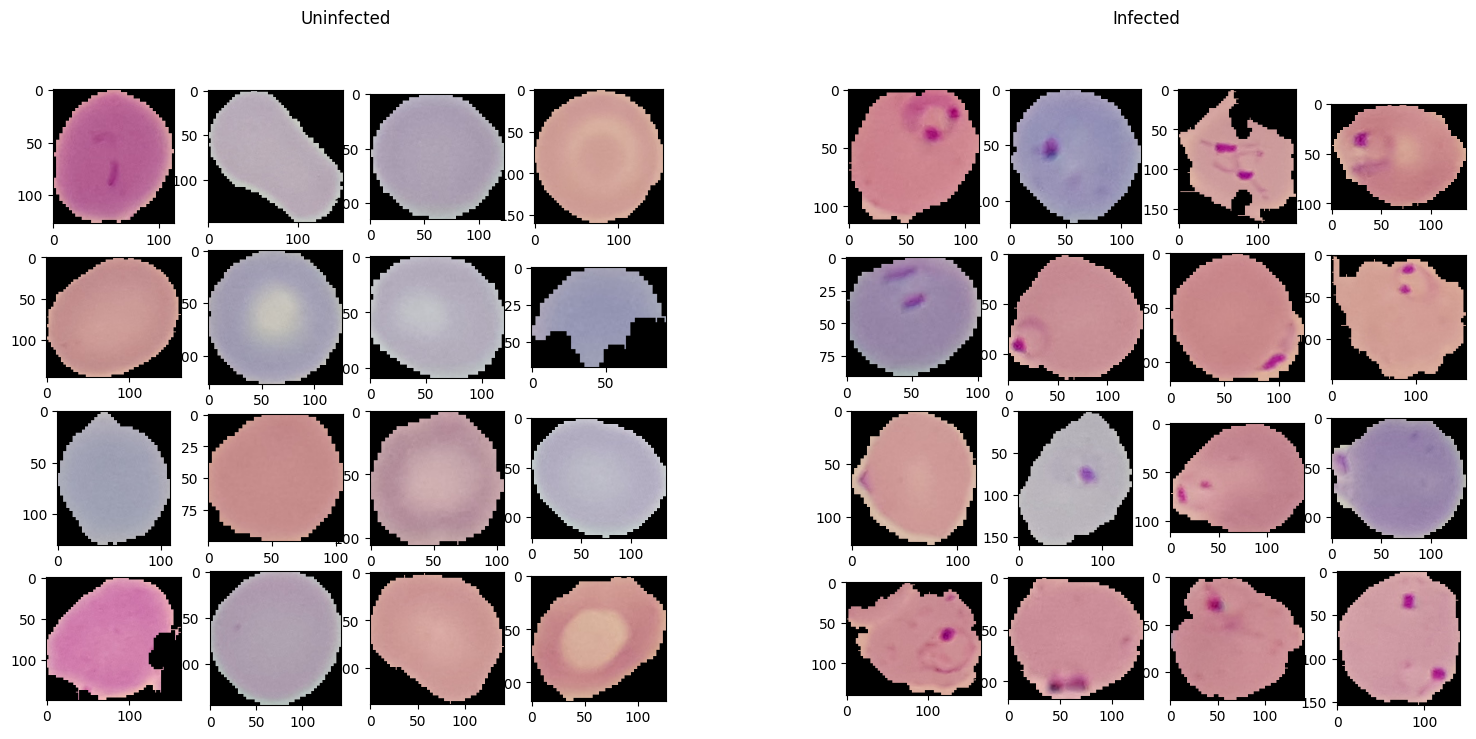

In [4]:
from blood_smears import plot_examples
plot_examples(uninfected_files,infected_files)

## Data Preprocessing

We'll define a popeline to resize and normalize the data ...

In [5]:
import torchvision.transforms as tt

pipeline = tt.Compose([tt.Resize((28,28)),
    tt.ToTensor()]) # automatically converts images to [0,1]

... subset the full dataset and split it into `train` and `test` sets ...

In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Lambda
from torch.utils.data import random_split, Subset

dataset = ImageFolder(base_dir, pipeline, target_transform= Lambda(lambda y: torch.tensor(abs(1-y)).float().unsqueeze(-1)))

subset_size = 5000
subset_indices = torch.randperm(len(dataset))[:subset_size]
subset = Subset(dataset, subset_indices)

train_size = int(0.8 * len(subset))
test_size = len(subset) - train_size
train, test = random_split(subset, [train_size, test_size])

... and define the dataloaders for both sets. For the training, we'll set `batch_size = 32`.

In [7]:
from torch.utils.data import DataLoader
batch_size = 32
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size * 5, shuffle=False)

## Fully-connected Neural Network

We'll define a Fully-connected Neural Network (FCNN) using `deeplay`. The FCNN has 2 layers with 128 features.

In [8]:
import deeplay as dl

FCNN = dl.MultiLayerPerceptron(in_features = 28 * 28 * 3,
                                hidden_features = [128, 128],
                                out_features = 1,
                                out_activation = torch.nn.Sigmoid,
)
FCNN.blocks.activation.configure(torch.nn.Sigmoid)

We'll define a classifier based on the FCNN architecture, including loss function, evaluation metrics and othe hyperparameters ...

In [9]:
import torchmetrics as tm

FCNN_classifier_template = dl.BinaryClassifier(
        model=FCNN,
        optimizer=dl.RMSprop(lr=.001),
        )

FCNN_classifier = FCNN_classifier_template.create()
print(FCNN_classifier)

BinaryClassifier(
  (loss): BCELoss()
  (train_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=test
  )
  (model): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LayerActivationNormalization(
        (layer): Linear(in_features=2352, out_features=128, bias=True)
        (activation): Sigmoid()
        (normalization): Identity()
      )
      (1): LayerActivationNormalization(
        (layer): Linear(in_features=128, out_features=128, bias=True)
        (activation): Sigmoid()
        (normalization): Identity()
      )
      (2): LayerActivationNormalization(
        (layer): Linear(in_features=128, out_features=1, bias=True)
        (activation): Sigmoid()
        (normalization): Identity()
      )
    )
  )
  (optimizer): RMSprop[RMSprop](lr=0.001, para

... and a trainer including other hyperparameters ...

In [10]:
FCNN_trainer = dl.Trainer(
    max_epochs=20, # How many times to run through the entire dataset
    accelerator="auto", # Use GPU if available
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


We'll start the training and visualize the evaluation metrics.

In [11]:
FCNN_trainer.fit(FCNN_classifier, train_loader)

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2023-11-20 15:58:42.873032: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

  | Name          | Type                 | Params
-------------------------------------------------------
0 | loss          | BCELoss              | 0     
1 | train_metrics | MetricCollection     | 0     
2 | val_metrics   | MetricCollection     | 0     
3 | test_metrics  | MetricCollection     | 0     
4 | model         | MultiLayerPerceptron | 317 K 
5 | optimizer     | RMSprop              | 0     
-------------------------------------------------------
31

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


We'll calculate the performance over the test set.

In [12]:
_ = FCNN_trainer.test(FCNN_classifier, test_loader)

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
testBinaryAccuracy_epoch    0.6570000052452087
     test_loss_epoch        0.6184727549552917
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## ROC curve and AUC
We'll use the function `plot_ROC_AUC` to get the ground truth and predictions for all the images in the test set, calculate the ROC and AUC, and visualize the results.
```python
def plot_ROC_AUC(classifier, dataset):
    from torch import tensor, stack
    from sklearn.metrics import roc_curve, auc
    from matplotlib import pyplot as plt

    im, gt = zip(*dataset)
    pred = classifier(tensor(stack(im))).tolist()
    # calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(gt, pred, pos_label=1) 
    roc_auc = auc(fpr, tpr) 

    # plot the ROC curve
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})", linewidth=2)
    plt.title("ROC curve")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.axis("square")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc = 'center right')
    plt.show()

    return im, gt, pred, roc_auc
```

/Users/841602/Documents/GitHub/DeepLearningCrashCourse/Ch03_CNN_image_analysis/Appl01/blood_smears.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = classifier(tensor(stack(im))).tolist()


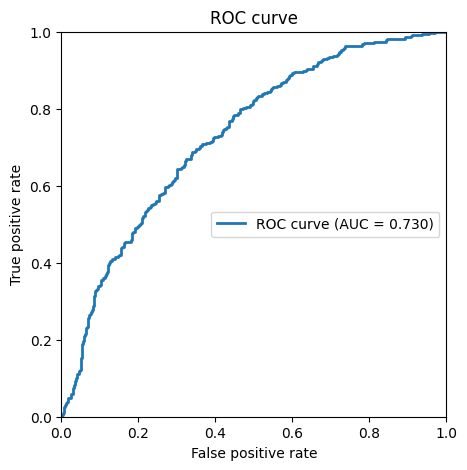

In [13]:
from blood_smears import plot_ROC_AUC
_,_,_,_ = plot_ROC_AUC(classifier = FCNN_classifier, dataset=test)

## Convolutional Neural Network with a dense top
We'll now build a convolutional neural network (CNN) with a FCNN at the end ...


In [14]:
CNN = dl.Sequential(
    dl.ConvolutionalNeuralNetwork(in_channels = 3, hidden_channels = [32, 32, 64], out_channels = 64),
    dl.Layer(torch.nn.AdaptiveAvgPool2d,output_size = 1),
    dl.MultiLayerPerceptron(in_features = 64, hidden_features = [], out_features = 1,out_activation = torch.nn.Sigmoid)
)
CNN[0].blocks[2].pool.configure(torch.nn.MaxPool2d, kernel_size = 2)

... define a classifier using the CNN ...

In [15]:
CNN_classifier_template = dl.BinaryClassifier(
    model=CNN, 
    optimizer=dl.RMSprop(lr=.001),
)

CNN_classifier = CNN_classifier_template.create()
print(CNN_classifier)

BinaryClassifier(
  (loss): BCELoss()
  (train_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=test
  )
  (model): Sequential(
    (0): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): PoolLayerActivationNormalization(
          (pool): Identity()
          (layer): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (normalization): Identity()
        )
        (1): PoolLayerActivationNormalization(
          (pool): Identity()
          (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (normalization): Identity()
        )
        (2): PoolLayerActivationNormalization(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=

... train it ...

In [16]:
CNN_trainer = dl.Trainer(
    max_epochs=20, # How many times to run through the entire dataset
    accelerator="auto", # Use GPU if available
)

CNN_trainer.fit(CNN_classifier, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | BCELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Sequential       | 65.6 K
5 | optimizer     | RMSprop          | 0     
---------------------------------------------------
65.6 K    Trainable params
0         Non-trainable params
65.6 K    Total params
0.263     Total estimated model params size (MB)


/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


... evaluate the performance over the test set ...

In [17]:
_ = CNN_trainer.test(CNN_classifier, test_loader)

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
testBinaryAccuracy_epoch    0.9350000023841858
     test_loss_epoch        0.18871890008449554
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


... and display the ROC curve with the AUC value.

/Users/841602/Documents/GitHub/DeepLearningCrashCourse/Ch03_CNN_image_analysis/Appl01/blood_smears.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = classifier(tensor(stack(im))).tolist()


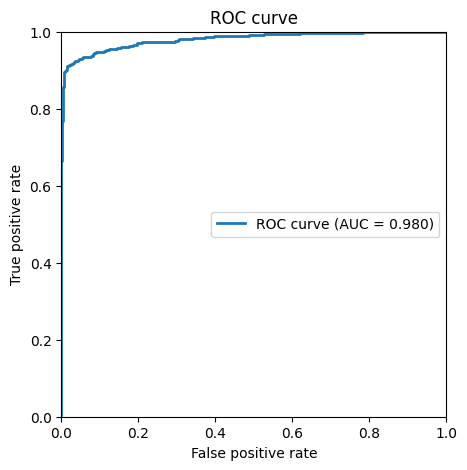

In [18]:
images, gt, pred, _ = plot_ROC_AUC(classifier=CNN_classifier, dataset=test)

## Failure analysis
We'll use a function to visualize some of the wrongly classified cells, looking for common patterns.
```python
def plot_failure(images, gt, pred, threshold = 0.5, num_of_plots = 5):
    from matplotlib import pyplot as plt 
    from numpy import array, squeeze   
    
    pred = array(pred).squeeze()
    gt = array(gt).squeeze()
    images = array(images)

    pred_class = pred > threshold

    false_positives = (pred_class == 1) & (gt == 0)
    false_positives_images = images[false_positives]

    false_negatives = (pred_class == 0) & (gt == 1)
    false_negatives_images = images[false_negatives]

    plt.figure(figsize=(num_of_plots*2, 5))
    for i in range(num_of_plots):

        # false positives
        plt.subplot(2, num_of_plots, i + 1)
        plt.imshow(false_positives_images[i].transpose(1, 2, 0))
        if i == 0:
            plt.title("False positives", fontsize=16, y=1.1)

        # false negatives
        plt.subplot(2, num_of_plots, i + num_of_plots + 1)
        plt.imshow(false_negatives_images[i].transpose(1, 2, 0))
        if i == 0:
            plt.title("False negatives", fontsize=16, y=1.1)

    plt.tight_layout()
    plt.show()
```

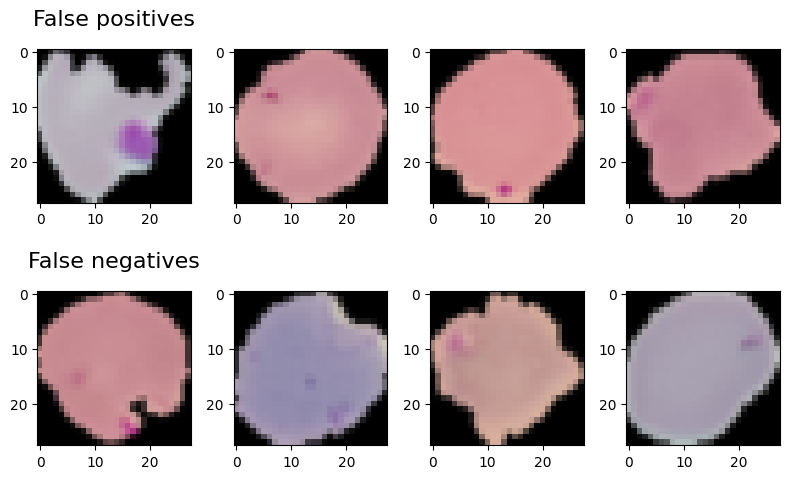

In [25]:
from blood_smears import plot_failure
plot_failure(images=images, gt=gt, pred=pred, threshold = 0.5, num_of_plots = 4)

## Filters
We can access and visualize the filters used by the network at a specific layer.

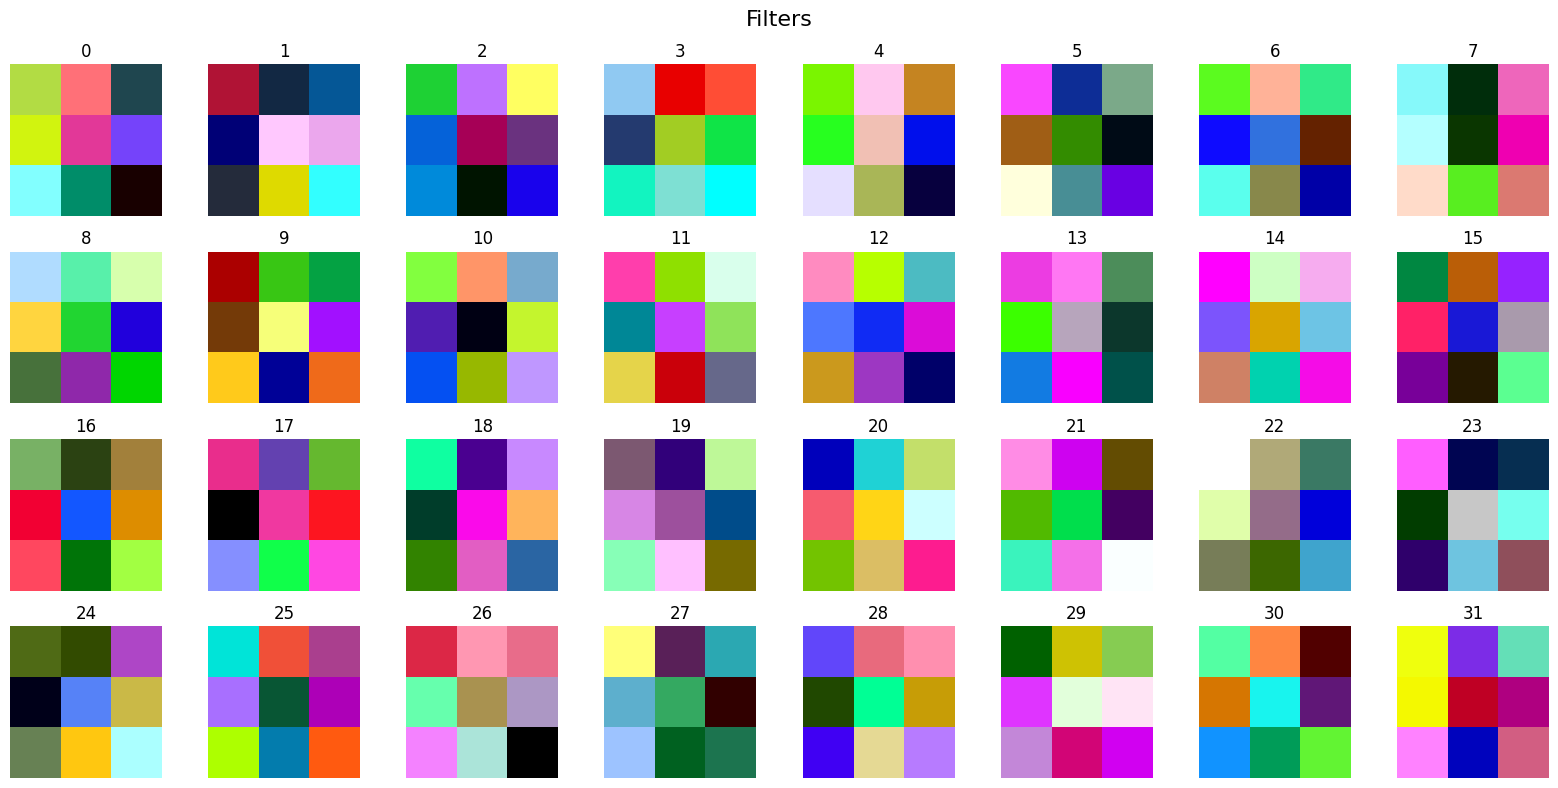

In [20]:
weights = CNN_classifier.model[0].input_block.layer.weight
w = weights.clone().detach()

from blood_smears import plot_filters_activations
plot_filters_activations(input = w, n_rows=4, label = 'Filters', normalize = True)

## Activations and Grad-CAM
To visualize the network feautures, we'll use `hooks`, functions that allows us to access the information that the model sees during forward and backward passes, such as activations and gradients, respectively. We'll define them as context manager classes, so that we can use them with the `with` statement:
```python
class fwd_hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o):
        print('Forward hook running...') 
        self.stored = o.detach().clone()
        print(f'Activations size: {self.stored.size()}')
    def __enter__(self, *args): 
        return self
    def __exit__(self, *args): 
        self.hook.remove()

class bwd_hook():
    def __init__(self, m):
        self.hook = m.register_full_backward_hook(self.hook_func)
    def hook_func(self, m, gi, go):
        print('Backward hook running...')
        self.stored = go[0].detach().clone()
        print(f'Gradients size: {self.stored.size()}')
    def __enter__(self, *args): 
        return self
    def __exit__(self, *args): 
        self.hook.remove()
```

We'll randomly pick the image of an infected smear.

In [21]:
import numpy as np
import matplotlib.image as mpimg

ind_infect = np.where((torch.cat(gt)==1).tolist())[0]
ind=np.random.choice(ind_infect,1)[0]

test_image = images[ind]
test_image_hr=mpimg.imread(dataset.imgs[subset.indices[test.indices[ind]]][0])

Activations and gradients at a specific layer can be obtained from the forward and backward pass, respectively ...

In [22]:
from blood_smears import fwd_hook, bwd_hook

test_layer = CNN_classifier.model[0].blocks[3].layer

with bwd_hook(test_layer) as bh:
    with fwd_hook(test_layer) as fh:
        out = CNN_classifier.model(test_image.unsqueeze(0)).backward()
activations = fh.stored
gradients = bh.stored

Forward hook running...
Activations size: torch.Size([1, 64, 14, 14])
Backward hook running...
Gradients size: torch.Size([1, 64, 14, 14])


... we can plot the activations ...

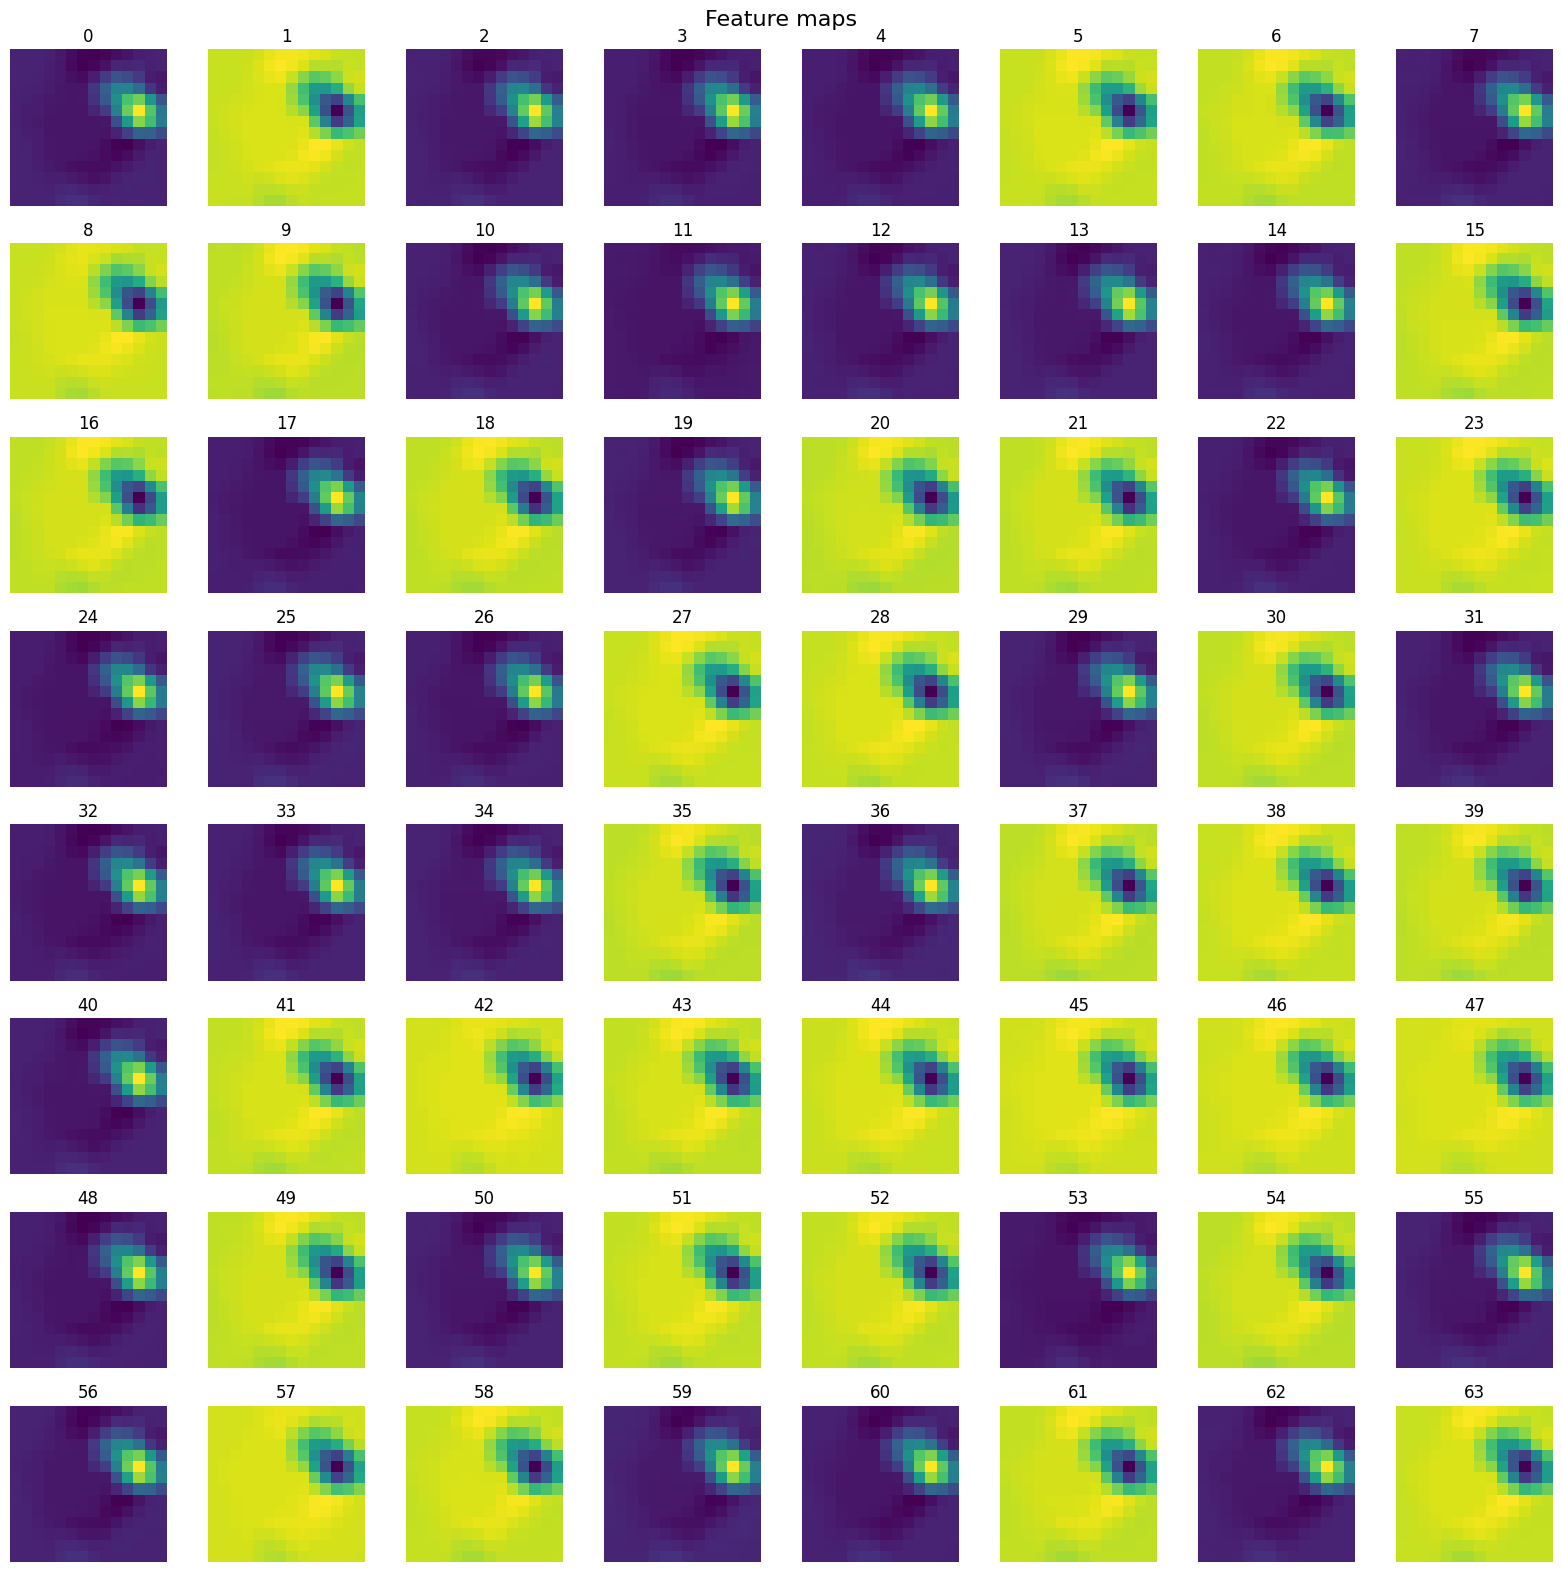

In [23]:
plot_filters_activations(input = activations.permute(1,0,2,3),n_rows=8,label = 'Feature maps', normalize = False)

... or combine gradients and activations to calculate Grad-CAM and inspect on which part of an image the CNN focuses on to predict its outputs. 

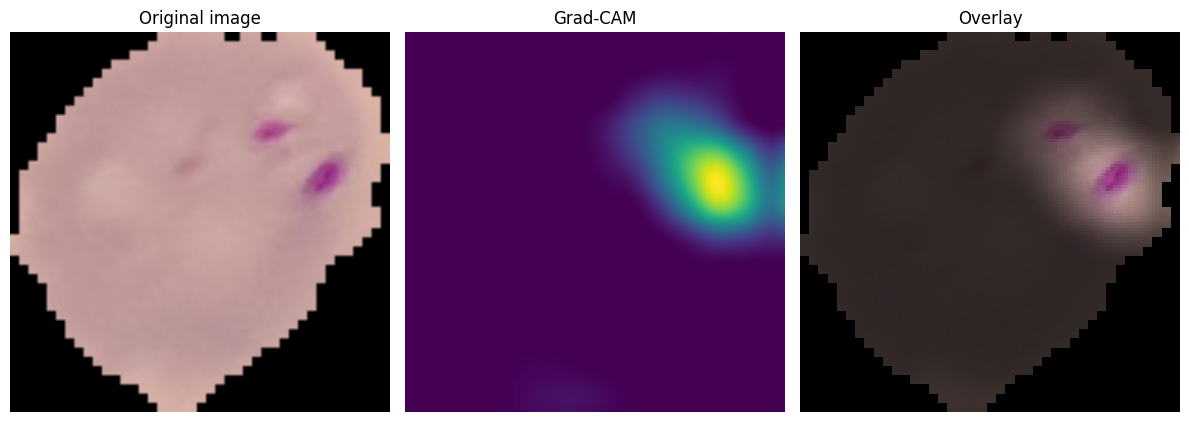

In [24]:
pooled_grad = gradients[0].mean(dim=[1,2], keepdim = True)
grad_cam = torch.nn.functional.relu((pooled_grad*activations[0]).sum(0)).detach().numpy()

from blood_smears import plot_gradcam
plot_gradcam(grad_cam, test_image_hr)